# COGS 108 - Final Project (Analysis of Restaurant Closure During Covid 19)

# Names

- Cecilia Hong A15599332
- Shirui Huang A15873275
- Zifan Zhang A15928594
- Liuyi Zhao A16174128
- Xun Zhu A16575924

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [  ] NO - keep private

# Overview

During the pandemic, we noticed that many restaurants were affected by COVID-19 heavily while some are not. Our group's project wanted to investigate what are the factors related to this difference. Specifically, whether restaurant closures in Oregon during the epidemic were related to restaurant popularity, price, pandemic intensity, and regional income. In the process of analysis, we used the method of data visualization to help us more intuitively understand the required information, which is of great help to our conclusion. Finally, we conclude that the closure of restaurants does have a certain relationship with the factors listed above, and the specific relationship will be described in the following analysis.

<a id='research_question'></a>
# Research Question

*Under the pandemic of COVID-19, is there a relationship between restaurants’ survival and the popularity and price of the restaurants, pandemic intensity, and regional income in Portland?*

<a id='background'></a>

## Background & Prior Work

*Because of the COVID-19 outbreak, there are lots of restaurants that were shut down, so we are interested in how covid affected restaurants, what kind of restaurants could survive under this specific environment, and what kind can not. For those restaurants that survived, what strategies they used to attract and maintain customers in such a difficult time for the food industry and how did the local economy and pandemic influenced them. After coming up with the idea to figure out the relationship between restaurants’ condition and their survival during COVID-19, we did some research online on similar topics.  * 

- 1) This article shows the restaurant’s closure condition in price, food category, and service.

https://medium.com/13-fund/analyzing-covid-19-restaurant-closures-with-yelp-data-f9116c7d563a

- 2) This article tells a story about a bakery in San Diego closed during the pandemic because its owner passed away.

https://www.nbcsandiego.com/news/local/which-san-diego-restaurants-have-closed-for-good/2323074/

- 3）This article suggests that 100,000 Restaurants Closed Six Months into Pandemic.

https://restaurant.org/news/pressroom/press-releases/100000-restaurants-closed-six-months-into-pandemic

# Hypothesis


*During the pandemic, though there were lots of restaurants shut down, there are some restaurants that survived. We believe it is because of their business strategy, performance post-pandemic, local economic and epidemic performance. *

1. Restaurants with higher rating and more reviews, which indicates that the restaurant is more popular have higher chances of surviving. Since the restaurant is performing well before the pandemic, it should continue to preform well during the pandemic.

2. Restaurants with higher price will have a higher chance of surviving since it's more profitable.

2. Restaurants located in places with higher average household income have higher chances of surviving, because people in that area will have more money to spend on food during the pandemic and more likely to eat in a restaurant.

3. Restaurants located in places with lower infected rates have higher chances of surviving, because that area is more safe for people to eat in a restaurant.

# Dataset(s)



<b>Yelp Dataset:</b>
https://www.yelp.com/dataset/download<br>
<b>Description:</b> This dataset contains information about restaurant price, rating, popularity, service, food category and whether it is closed. <br>
<b>Format:</b> JSON <br>
<b>Observations:</b> 160585 <br>

<hr>

<b>Oregon COVID-19 Case Count Data by County:</b>
https://public.tableau.com/profile/oregon.health.authority.covid.19#!/vizhome/OregonCOVID-19CasesbyZIPCode-SummaryTable/CasesbyZIPCodeSummaryTable?publish=yes<br>
<b>Description:</b> This dataset contains the number of daily COVID-19 Cases from 03/04/2020 to 04/26/2021 in Oregon by zip code. <br>
<b>Format:</b> XLSX <br>
<b>Observations:</b> 255<br>


<hr>


<b>Uszipcode 0.2.0 db:</b>
https://datahub.io/machu-gwu/uszipcode-0.2.0-db#pandas<br>
<b>Description:</b> This dataset is used to find the income data by zip code. <br>
<b>Format:</b> DB <br>
<b>Observations:</b> 41877<br>


<hr>


<b>Cartographic Boundary Files - Shapefile:</b>
https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html<br>
<b>Description:</b> This dataset is used to find the geospatial shape of each zip code. <br>
<b>Format:</b> SHP <br>
<b>Observations:</b> 41877<br>

# Setup

In [1]:
!pip install geopandas
import json
import numpy as np 
import pandas as pd 
import geopandas as gpd
import sqlite3
import seaborn as sns
import patsy
import statsmodels.api as sm
from shapely.geometry import LineString, MultiPoint, Polygon
from scipy.stats import pearsonr, norm, ttest_ind
sns.set(font_scale=1, style="white", rc={'figure.figsize':(11.7,8.27)})

In [2]:
# read in zip code data
con = sqlite3.connect('db.sqlite')
zipcode = pd.read_sql_query("SELECT * from zipcode", con)
# read in covid data
covid_xlsx = pd.read_excel("Cases by ZIP Code.xlsx")
# read in yelp data
yelp_json = []
for line in open("yelp_academic_business.json", encoding="utf-8"):
    yelp_json.append(json.loads(line))
# read in geographic data
geo = gpd.read_file('cb_2018_us_zcta510_500k.shp')

In [72]:
geo

,postal_code,geometry
0,36083,"MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ..."
1,35441,"MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ..."
2,35051,"POLYGON ((-86.74384 33.25002, -86.73802 33.251..."
3,35121,"POLYGON ((-86.58527 33.94743, -86.58033 33.948..."
4,35058,"MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ..."
...,...,...
33139,10983,"POLYGON ((-73.96564 41.02787, -73.96612 41.029..."
33140,50460,"POLYGON ((-92.80629 43.23026, -92.80354 43.232..."
33141,40870,"POLYGON ((-83.19264 36.91650, -83.19086 36.916..."
33142,40914,"POLYGON ((-83.62748 37.07419, -83.62455 37.073..."


# Data Cleaning

The first row of the covid data are the column names, so we set them as the column names and dropped them from the data. After that we set the indices to the zip code so we can get the data with a zip code. There is missing data, but we kept it and will process it when we put the data together.

In [3]:
covid_xlsx = covid_xlsx.drop(columns = 'Cases by ZIP Code Summary Table')
covid_xlsx.columns = covid_xlsx.iloc[0]
covid = covid_xlsx.drop(index=[0])
covid = covid.replace('*N/A', 0)
covid = covid.replace('<1,000', 0)
covid['Cases Per 100,000'] = covid['Cases Per 100,000'].apply(float)
covid['Population Count'] = covid['Population Count'].apply(float)

print(covid.shape)
covid.head()


(431, 4)


,ZIP Code,Case Count,Population Count,"Cases Per 100,000"
1,89421,0,0.0,0.0
2,97001,0,0.0,0.0
3,97002,914,5623.0,16254.7
4,97003,3950,25884.0,15260.4
5,97004,642,4388.0,14630.8


The yelp data contains information of all states in the US, but we only need the data of Oregon, so we select only the data of Oregon. We also only care about the data of restaurants, so we remove all businesses of other categories. Since this dataset contains missing data, we drop those missing data and reset the index afterwards.

In [4]:
df = pd.DataFrame(yelp_json)
yelp_data = df[df['state'] == "OR"]
yelp_data = yelp_data.dropna()
restaurant = yelp_data[yelp_data['categories'].str.contains('Restaurants')].reset_index().drop(columns = 'index')
print(restaurant.shape)
restaurant.head()


(6319, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
1,jx91IMdGOmLOo8h_F9z39g,Cleary's Restaurant & Spirits,12429 NE Glisan St,Portland,OR,97230,45.526473,-122.535323,3.5,19,1,"{'RestaurantsGoodForGroups': 'True', 'Alcohol'...","Nightlife, Sandwiches, Seafood, Restaurants","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."
2,5PsApTz-WqhF_-8mfqGtGw,Cafe Yumm!,301 SW Morrison St,Portland,OR,97204,45.518450,-122.675723,3.5,158,1,"{'OutdoorSeating': 'True', 'GoodForKids': 'Tru...","Vegetarian, Vegan, Sandwiches, Soup, American ...","{'Monday': '10:0-17:0', 'Tuesday': '10:0-17:0'..."
3,HMXiuCxHDXqMH1hBpaHd9g,Whole Time Chicken,,Portland,OR,97215,45.516241,-122.597527,5.0,7,0,"{'OutdoorSeating': 'True', 'RestaurantsTableSe...","Food Stands, Restaurants, Sandwiches","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'..."
4,ZA3u0Nu5V6TqkcYh8U0zdg,B Street Coffee House,2190 W Burnside St,Portland,OR,97210,45.523074,-122.696206,4.5,131,0,"{'Caters': 'False', 'RestaurantsAttire': 'u'ca...","Restaurants, Food, Sandwiches, Breakfast & Bru...","{'Monday': '6:30-15:0', 'Tuesday': '6:30-15:0'..."


The zipcode data contains information of all zipcodes in the US, but we only need the data of Oregon, so we select only the data of Oregon. We also only care about the income data and we need the county name of each zipcode, so we select only the income and county column.

In [5]:
zipcode = zipcode[zipcode['state'] == "OR"]
zipcode = zipcode[['zipcode', 'county', 'median_household_income']]
print(zipcode.shape)
zipcode.head()

(491, 3)


,zipcode,county,median_household_income
29641,97001,Wasco County,56538.0
29642,97002,Marion County,65150.0
29643,97004,Clackamas County,77829.0
29644,97005,Washington County,39677.0
29645,97006,Washington County,60407.0


We merged the geo dataset with the zipcode dataset and covid dataset so we can present these data in a geospatial plot.

In [7]:
geo = geo[['ZCTA5CE10', 'geometry']]
geo.columns = ['postal_code', 'geometry']
zipgeo = zipcode.merge(geo, left_on='zipcode', right_on='postal_code')
zipgeo = zipgeo.merge(covid, left_on='zipcode', right_on='ZIP Code')
zipgeo = gpd.GeoDataFrame(zipgeo, geometry='geometry')
zipgeo = zipgeo.replace('*N/A', '0')
zipgeo = zipgeo.replace('<1,000', '0')
zipgeo = zipgeo.drop(columns = ['postal_code', 'ZIP Code'])

print(zipgeo.shape)
zipgeo.head()

(417, 9)


,zipcode,county,median_household_income,postal_code,geometry,ZIP Code,Case Count,Population Count,"Cases Per 100,000"
0,97001,Wasco County,56538.0,97001,"POLYGON ((-120.91818 44.94079, -120.90183 44.9...",97001,0,0.0,0.0
1,97002,Marion County,65150.0,97002,"POLYGON ((-122.90036 45.18370, -122.89879 45.1...",97002,914,5623.0,16254.7
2,97004,Clackamas County,77829.0,97004,"POLYGON ((-122.56429 45.29046, -122.56356 45.2...",97004,642,4388.0,14630.8
3,97005,Washington County,39677.0,97005,"POLYGON ((-122.83200 45.49256, -122.83258 45.4...",97005,4389,24906.0,17622.3
4,97006,Washington County,60407.0,97006,"MULTIPOLYGON (((-122.85681 45.55099, -122.8559...",97006,7308,63036.0,11593.4


In [78]:
zipgeo.head()

,zipcode,county,median_household_income,geometry,Case Count,Population Count,"Cases Per 100,000"
0,97001,Wasco County,56538.0,POLYGON EMPTY,0,0.0,0.0
1,97002,Marion County,65150.0,POLYGON EMPTY,914,5623.0,16254.7
2,97004,Clackamas County,77829.0,POLYGON EMPTY,642,4388.0,14630.8
3,97005,Washington County,39677.0,"POLYGON ((-122.83258 45.49325, -122.83001 45.4...",4389,24906.0,17622.3
4,97006,Washington County,60407.0,"MULTIPOLYGON (((-122.85591 45.55178, -122.8539...",7308,63036.0,11593.4


We find the local income and covid cases of each restaurant in the restaurant dataset with the covid dataset and the zipcode dataset based on and zipcode. Then we extract the price information from the attributes columnb in the restaurant dataset. Since some restaurants do not contain the price attribute, we drop the missing data again and reset the index. After that we converted the prices from string to integer and converted is_open from integer to boolean value. 

In [8]:
restaurant = restaurant.merge(covid, left_on='postal_code', 
                              right_on='ZIP Code').merge(zipcode, left_on='postal_code', 
                                                         right_on='zipcode')
restaurant['price'] = restaurant['attributes'].apply(lambda x: x['RestaurantsPriceRange2'] 
                                                     if 'RestaurantsPriceRange2' in x.keys() else np.nan)
restaurant = restaurant.replace(to_replace='None', value=np.nan).dropna().reset_index()
restaurant['price'] = restaurant['price'].apply(lambda x: int(x))


print(restaurant.shape)
restaurant.head()

(5631, 24)


,index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,hours,geometry,ZIP Code,Case Count,Population Count,"Cases Per 100,000",zipcode,county,median_household_income,price
0,0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,...,"{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",POINT (-122.59333 45.58891),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,2
1,1,vjXpK0i3P0gktiMd9GKUcQ,Sherpa Nirvana,5427 NE 42nd Ave,Portland,OR,97218,45.562358,-122.620640,4.5,...,"{'Wednesday': '10:30-18:0', 'Thursday': '10:30...",POINT (-122.62064 45.56236),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,1
2,2,hS1QkoZz9KvMZMJfDCBTug,McDonald's,"7000 NE Airport Way, Ste 220",Portland,OR,97218,45.589565,-122.598465,2.5,...,"{'Monday': '4:0-23:0', 'Tuesday': '4:0-23:0', ...",POINT (-122.59847 45.58957),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,1
3,4,8nkNfbKDFn27p0ZDPGKihw,Stanford's Restaurant & Bar,7000 NE Airport Way,Portland,OR,97218,45.588909,-122.593986,4.0,...,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",POINT (-122.59399 45.58891),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,2
4,5,M3PBkDMIY5fcfZsWPBNH6A,Sub Shop,4331 NE Killingsworth St,Portland,OR,97218,45.563063,-122.618359,4.0,...,"{'Monday': '10:0-20:0', 'Tuesday': '10:0-20:0'...",POINT (-122.61836 45.56306),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,1


We use the longitude and latitude in the restaurant dataset and convert them into geographical points and put them in a geopandas dataframe.

In [10]:
rgeo = gpd.GeoDataFrame(restaurant, geometry=gpd.points_from_xy(restaurant.longitude, restaurant.latitude))
rgeo.head()

,index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,hours,geometry,ZIP Code,Case Count,Population Count,"Cases Per 100,000",zipcode,county,median_household_income,price
0,0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,...,"{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",POINT (-122.59333 45.58891),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,2
1,1,vjXpK0i3P0gktiMd9GKUcQ,Sherpa Nirvana,5427 NE 42nd Ave,Portland,OR,97218,45.562358,-122.620640,4.5,...,"{'Wednesday': '10:30-18:0', 'Thursday': '10:30...",POINT (-122.62064 45.56236),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,1
2,2,hS1QkoZz9KvMZMJfDCBTug,McDonald's,"7000 NE Airport Way, Ste 220",Portland,OR,97218,45.589565,-122.598465,2.5,...,"{'Monday': '4:0-23:0', 'Tuesday': '4:0-23:0', ...",POINT (-122.59847 45.58957),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,1
3,4,8nkNfbKDFn27p0ZDPGKihw,Stanford's Restaurant & Bar,7000 NE Airport Way,Portland,OR,97218,45.588909,-122.593986,4.0,...,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",POINT (-122.59399 45.58891),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,2
4,5,M3PBkDMIY5fcfZsWPBNH6A,Sub Shop,4331 NE Killingsworth St,Portland,OR,97218,45.563063,-122.618359,4.0,...,"{'Monday': '10:0-20:0', 'Tuesday': '10:0-20:0'...",POINT (-122.61836 45.56306),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,1


Since the yelp dataset contains only restaurants in Portland, we need to crop the region boundaries in zipgeo so it can match rgeo.

In [11]:
rgeo.geometry.total_bounds

array([-122.8989772 ,   45.3510084 , -122.4520709 ,   45.64212348])

In [12]:
minx, miny, maxx, maxy = rgeo.geometry.total_bounds
envelope = gpd.GeoDataFrame([[Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx,miny), (minx, miny)])]], 
                            columns=['geometry'])
zipgeo['geometry'] = zipgeo.intersection(envelope.unary_union)

We select only the columns that we will use for our reseach. 

In [15]:
restaurant

,index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,hours,geometry,ZIP Code,Case Count,Population Count,"Cases Per 100,000",zipcode,county,median_household_income,price
0,0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,...,"{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",POINT (-122.59333 45.58891),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,2
1,1,vjXpK0i3P0gktiMd9GKUcQ,Sherpa Nirvana,5427 NE 42nd Ave,Portland,OR,97218,45.562358,-122.620640,4.5,...,"{'Wednesday': '10:30-18:0', 'Thursday': '10:30...",POINT (-122.62064 45.56236),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,1
2,2,hS1QkoZz9KvMZMJfDCBTug,McDonald's,"7000 NE Airport Way, Ste 220",Portland,OR,97218,45.589565,-122.598465,2.5,...,"{'Monday': '4:0-23:0', 'Tuesday': '4:0-23:0', ...",POINT (-122.59847 45.58957),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,1
3,4,8nkNfbKDFn27p0ZDPGKihw,Stanford's Restaurant & Bar,7000 NE Airport Way,Portland,OR,97218,45.588909,-122.593986,4.0,...,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",POINT (-122.59399 45.58891),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,2
4,5,M3PBkDMIY5fcfZsWPBNH6A,Sub Shop,4331 NE Killingsworth St,Portland,OR,97218,45.563063,-122.618359,4.0,...,"{'Monday': '10:0-20:0', 'Tuesday': '10:0-20:0'...",POINT (-122.61836 45.56306),97218,2448,14561.0,16812.0,97218,Multnomah County,47099.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5626,6276,nZ9gAde4qhL-OdBDDf1f8A,Decoy,10710 NW Saint Helens Rd,Portland,OR,97231,45.599037,-122.785717,4.0,...,"{'Monday': '11:0-23:0', 'Tuesday': '10:0-23:0'...",POINT (-122.78572 45.59904),97231,416,4280.0,9719.6,97231,Multnomah County,87281.0,1
5627,6277,AN8XpqhVVrgT-5bII1k7Uw,Lighthouse Inn Restaurant and Bar,10808 NW Saint Helens Rd,Portland,OR,97231,45.599377,-122.786298,3.5,...,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",POINT (-122.78630 45.59938),97231,416,4280.0,9719.6,97231,Multnomah County,87281.0,1
5628,6278,EWLprry6mnOvon68ifHNGA,Five Guys,2343 NW 185th St,Hillsboro,OR,97123,45.537197,-122.868070,3.0,...,"{'Monday': '10:30-23:0', 'Tuesday': '10:30-23:...",POINT (-122.86807 45.53720),97123,8239,44537.0,18499.2,97123,Washington County,64599.0,2
5629,6279,7KjhaMOfyRtfK9hdBKBQ9Q,Crepes Plus,38400 Pioneer Blvd,San dy,OR,97055,45.463810,-122.579516,4.5,...,"{'Monday': '7:0-18:0', 'Tuesday': '7:0-18:0', ...",POINT (-122.57952 45.46381),97055,3152,17350.0,18167.1,97055,Clackamas County,61733.0,1


In [16]:
restaurant = restaurant.get(['stars', 'review_count', 'is_open', 'median_household_income', 'price','Cases Per 100,000'])
restaurant = restaurant.rename(columns = {'median_household_income': 'income', 'Cases Per 100,000': 'cases'})

restaurant

,stars,review_count,is_open,income,price,cases
0,4.0,126,1,47099.0,2,16812.0
1,4.5,22,1,47099.0,1,16812.0
2,2.5,48,1,47099.0,1,16812.0
3,4.0,214,0,47099.0,2,16812.0
4,4.0,28,1,47099.0,1,16812.0
...,...,...,...,...,...,...
5626,4.0,49,1,87281.0,1,9719.6
5627,3.5,48,0,87281.0,1,9719.6
5628,3.0,137,1,64599.0,2,18499.2
5629,4.5,59,1,61733.0,1,18167.1


# Data Analysis & Results

Before starting the analysis of a specific pair of variables, we want to have a brief overview of the relationships among the variables “stars”, “review_count”, “is_open”, “income”, “price”, and “cases”, in order to have a better understanding the relationship between different features, we decide to use Scatterplot Matrix to predict the relationship between each pair of the variables. Below is the scatter plot matrix with the x-axis and the y-axis to be the above six variables.


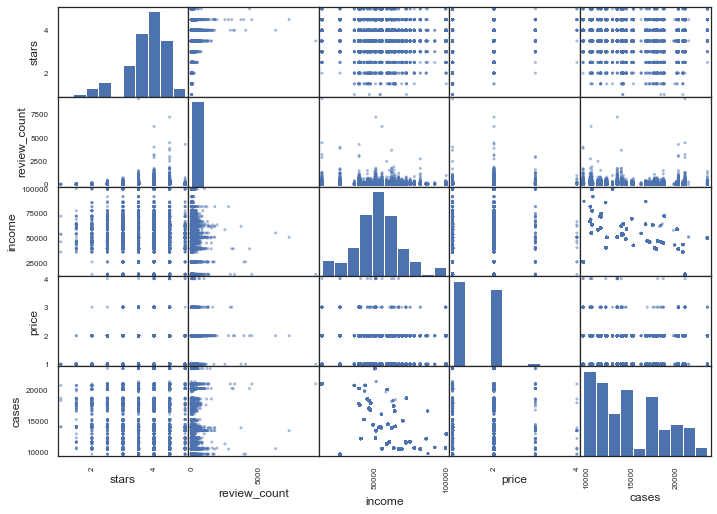

In [17]:
fig = pd.plotting.scatter_matrix(restaurant[['stars', 'review_count', 'income', 'price', 'cases']])

We found that the histogram of review_count skewed right too much, so we applied a log10-transformation to the restaurant review_count data. The below histgram represent the distrubution of the reviews after log10-tranformation among restaurants. The y-axis is the number of the restaurants and the x-axis is the number of reviews each restaurant recived. Then the histogram looks more like a normal distribution.

<AxesSubplot:xlabel='review_log10', ylabel='Count'>

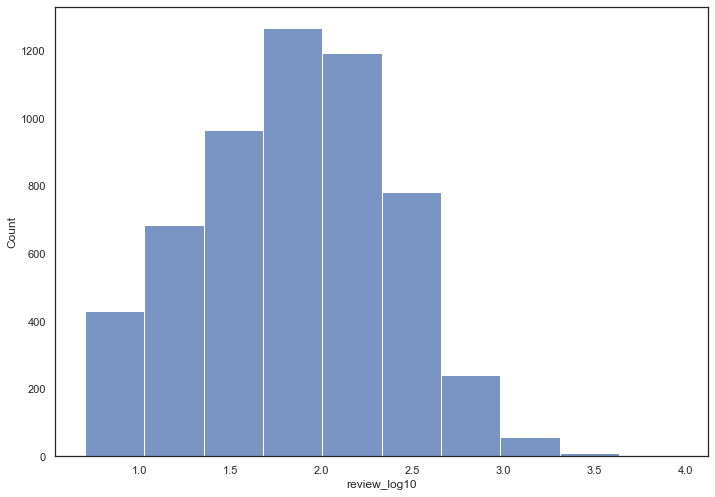

In [34]:
restaurant['review_log10'] = np.log10(restaurant['review_count'])
sns.histplot(x = "review_log10", data = restaurant, bins = 10, palette = 'muted')


In the chart below we observed that the distribution of number of reviews open restaurants received is more skewed left compare to the distribution of number of reviews closed restaurants received. This shows that restaurants that got more reviews are more likely to survive. This supports our hypothesis because restaurants with reviews are generally more popular than restaurants that received fewer reviews.

Text(0.5, 1.0, 'Restaurant Survival VS Review Count')

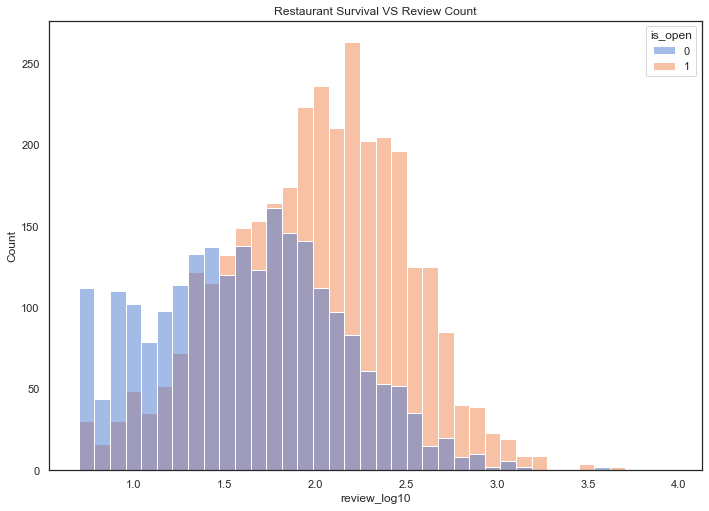

In [36]:
restaurant['review_log10'] = np.log10(restaurant['review_count'])
p = sns.histplot(x="review_log10", data=restaurant, hue='is_open', palette = 'muted')
p.set_title('Restaurant Survival VS Review Count')

Now, we want to take a look at the relationship between income, number of cases, and the restaurant's average price and the survival of the restaurants seperatly. <br>

In our first plot, we are observing the relationship between is_open and price. Here we have the range of prices are 1, 2, 3, and 4, which is increasing order.
From Yelp:
- Range 1: Below 10 dollars 
- Range 2: 11 dollars to 30 dollars 
- Range 3: 31 dollars to 60 dollars
- Range 4: Above 60 dollars

As you can see, most of the restaurants at price range 1 and 2 survived during the pendamic so far. Starting from price range 2, the proportion of the survived restaurants decrese as the price range increases, and at price range 4, the proportion of the closed restaurants exceed those of the survived restaurants. This indicates that the restaurants at a relatively lower price level (below 30 dollars) is easier to survive during the pandemic.<br>


Text(0.5, 1.0, 'Restaurant Survival VS Pricec')

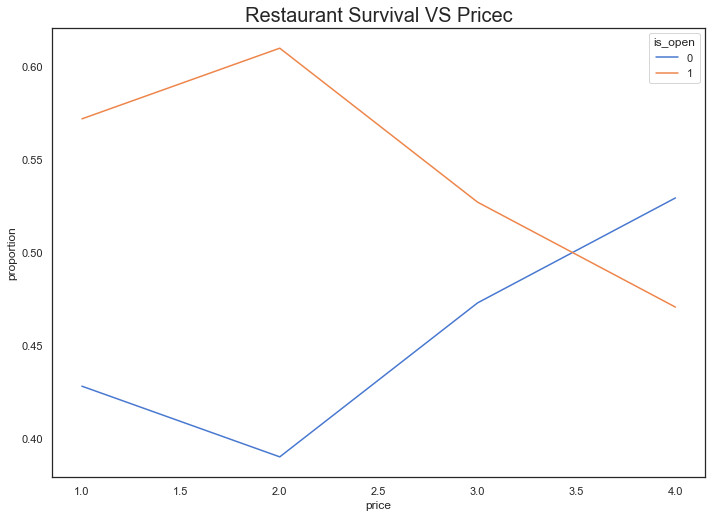

In [40]:
a = restaurant.groupby(by=['is_open', 'price']).count()
b = restaurant.groupby(by=['price']).count()
c = a.assign(proportion = a['stars'] / b['stars'])
prop_df = c.reset_index().loc[:,['is_open', "price", "proportion"]]
p = sns.lineplot(x='price', y='proportion', hue='is_open', data=prop_df, palette = "muted")
p.set_title('Restaurant Survival VS Pricec', fontsize = 20)

In [41]:
restaurant

,stars,review_count,is_open,income,price,cases,review_log10
0,4.0,126,1,47099.0,2,16812.0,2.100371
1,4.5,22,1,47099.0,1,16812.0,1.342423
2,2.5,48,1,47099.0,1,16812.0,1.681241
3,4.0,214,0,47099.0,2,16812.0,2.330414
4,4.0,28,1,47099.0,1,16812.0,1.447158
...,...,...,...,...,...,...,...
5626,4.0,49,1,87281.0,1,9719.6,1.690196
5627,3.5,48,0,87281.0,1,9719.6,1.681241
5628,3.0,137,1,64599.0,2,18499.2,2.136721
5629,4.5,59,1,61733.0,1,18167.1,1.770852


For the table below, we looked at the opening and closing of restaurants and star reviews of the restaurant's performance. When we looked at the chart, we were surprised to find that the stores with lower star reviews were still in business compared with most of the stores. On the contrary, the stores with higher star reviews had a higher closing rate. Our hypothesis is that the price of the restaurants might be the cofounder in this case. Low-star restaurants tend to be fast-food restaurants, which can survive because they don't have high costs and they can easily adapt to delivery services. On the contrary, the higher-star restaurants, because they have high requirements for the food they prepare, and it is not so easy to transform into takeaway service, many restaurants have closed down.

Text(0.5, 1.0, 'Restaurant Survival VS Rating Stars')

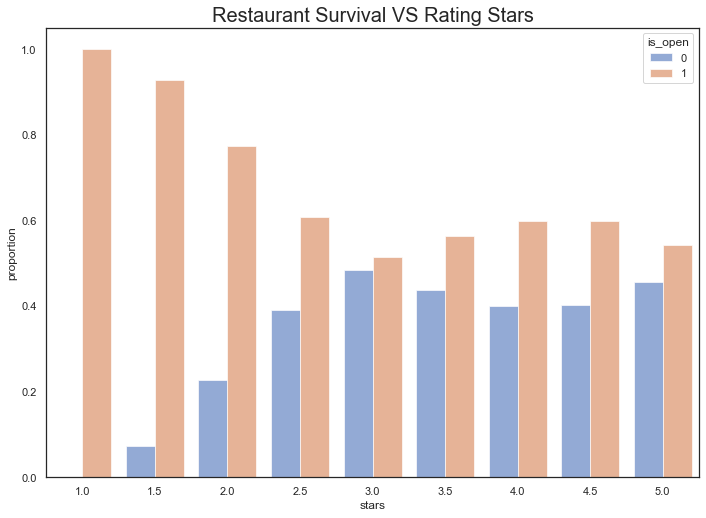

In [21]:
a = restaurant.groupby(by=['is_open', 'stars']).count()
b = restaurant.groupby(by=['stars']).count()
c = a.assign(proportion = a['income'] / b['income'])
prop_df = c.reset_index().loc[:,['is_open', "stars", "proportion"]]
p = sns.barplot(x='stars', y='proportion', hue='is_open', data=prop_df, palette = "muted", alpha = 0.65)
p.set_title('Restaurant Survival VS Rating Stars', fontsize = 20)

The chart below looks at the relationship between star ratings and prices. We can see that the lower the star level, the price of it is the cheapest. When the star level becomes higher, the price of some restaurants will also become higher, but we can also observe that most of the price ranges are 1 and 2. Thus, the price of the lower middle restaurants is still occupied a relatively large share of the market. We also observed that the pattern of this chart is very similar to the pattern of the previous chart, so instead of stars, the survival of restaurants and their prices maybe highly related.

Text(0.5, 1.0, 'Star VS Price')

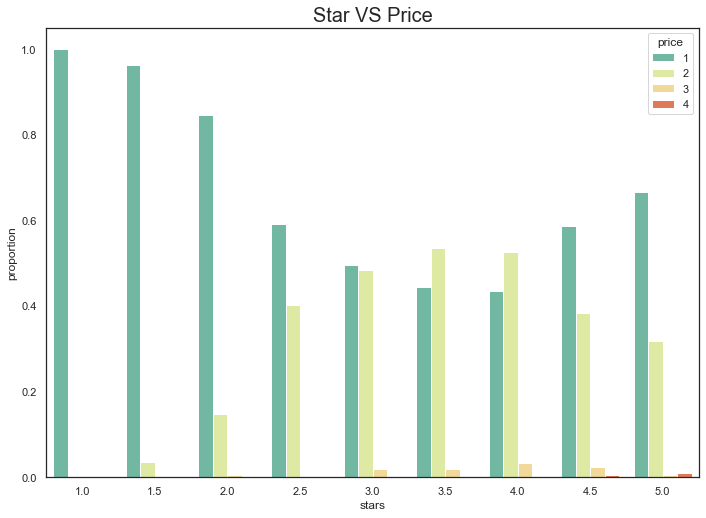

In [68]:
a = restaurant.groupby(by=['price', 'stars']).count()
b = restaurant.groupby(by=['stars']).count()
c = a.assign(proportion = a['income'] / b['income'])
prop_df = c.reset_index().loc[:,['price', "stars", "proportion"]]
p = sns.barplot(x='stars', y='proportion', hue='price', data=prop_df, palette = "Spectral_r")
p.set_title('Star VS Price', fontsize = 20)

In [63]:
restaurant.groupby(by=['price', 'stars']).count()

review_count  is_open  income  cases  review_log10
price stars                                                    
1     1.0               5        5       5      5             5
      1.5              53       53      53     53            53
      2.0             149      149     149    149           149
      2.5             174      174     174    174           174
      3.0             326      326     326    326           326
      3.5             587      587     587    587           587
      4.0             772      772     772    772           772
      4.5             684      684     684    684           684
      5.0             124      124     124    124           124
2     1.5               2        2       2      2             2
      2.0              26       26      26     26            26
      2.5             118      118     118    118           118
      3.0             319      319     319    319           319
      3.5             707      707     707    707           707
      4.0             934      934     934    934           934
      4.5             446      446     446    446           446
      5.0              59       59      59     59            59
3     2.0               1        1       1      1             1
      2.5               1        1       1      1             1
      3.0              13       13      13     13            13
      3.5              26       26      26     26            26
      4.0              60       60      60     60            60
      4.5              27       27      27     27            27
      5.0               1        1       1      1             1
4     2.5               1        1       1      1             1
      3.5               1        1       1      1             1
      4.0               6        6       6      6             6
      4.5               7        7       7      7             7
      5.0               2        2       2      2             2

In [64]:
restaurant.groupby(by=['price', 'stars']).count()
observed = pd.DataFrame({'price_1' : [5,53,149,174,326,587,772,684,124], 'price_2': [0,2,26,118,319,707,934,446,59],'price_3': [0,0,1,1,13,26,60,27,1],'price_4': [0,0,0,1,0,1,6,7,2]})
observed

,price_1,price_2,price_3,price_4
0,5,0,0,0
1,53,2,0,0
2,149,26,1,0
3,174,118,1,1
4,326,319,13,0
5,587,707,26,1
6,772,934,60,6
7,684,446,27,7
8,124,59,1,2


In [66]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(observed, correction=True)
p

2.879151472451681e-44

In the chart below, we observed that overall, covid infection rate doesn't affect restaurant close down that much since the number of restaurants that are still open and the number of restaurants that are closed down have similar pattern over covid infection.

<AxesSubplot:xlabel='cases', ylabel='Count'>

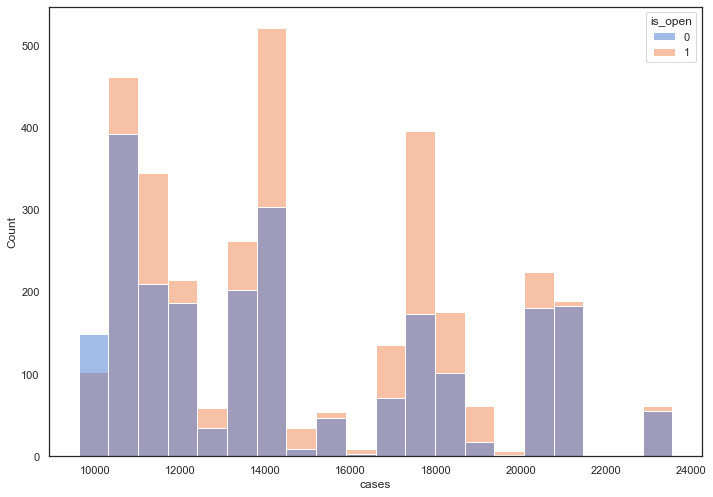

In [23]:
sns.histplot(x="cases", data=restaurant, hue='is_open', palette = 'muted')

In the chart below, we observed that overall, restaurants at places with higher average income is more likely to survive through the pandemic.

Text(0.5, 1.0, 'Restaurant Survival VS Income')

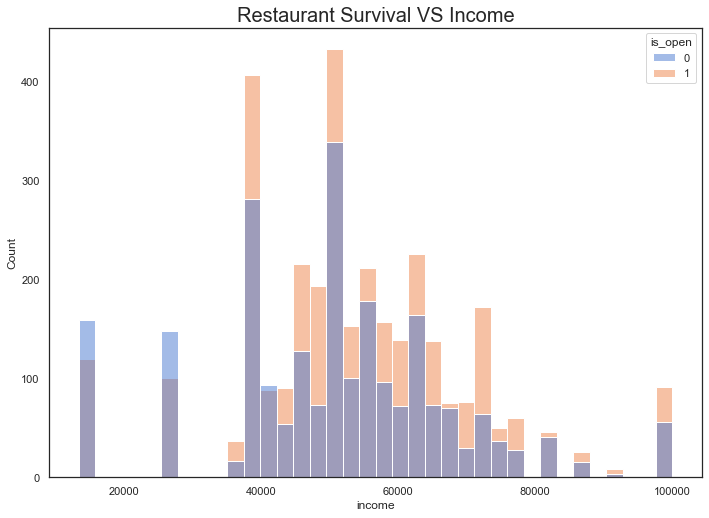

In [79]:
p = sns.histplot(x="income", data=restaurant, hue='is_open', palette = 'muted')
p.set_title('Restaurant Survival VS Income', fontsize = 20)

In [71]:
# AB Testing 

# H0: There is no difference in the restaurant survival between high income and low income area 
# H1: There is a difference in the restaurant survival between high income and low income area

In [26]:
new_df = restaurant[['is_open','income']]
AB_test = new_df.groupby(by = 'is_open').mean()
observed_diff = AB_test['income'][0] -  AB_test['income'][1]
observed_diff

-3033.474921264751

In [27]:
control_diff = np.array([])
for i in np.arange(500): 
    control = new_df.assign(permutation = np.random.permutation(new_df['income']))
    diff_df = control.groupby(by = 'is_open').mean().get('permutation')
    control_diff = np.append(control_diff, diff_df.loc[0] - diff_df.loc[1])
    

In [28]:
p_value = np.count_nonzero(control_diff <= observed_diff)/500
p_value

0.0

Looking at the map and based on the above analysis, we can find that most of the restaurants in Oregon are concentrated in the city of Portland. Looking at the chart below, we can see that the shades of color represent the median household income, the yellow dots indicate closed restaurants and the orange dots indicate restaurants that are still open. We can see that in the very middle of the map is the area with the highest household income in Portland, and we can also see that most of the restaurants are located around this area. By naked eye observation, we can find that half of the restaurants are still open and half of the restaurants are closed. Therefore, the pandemic has a relatively large impact on the normal operation of restaurants. For this chart, there is no direct correlation between the closure of restaurants and household income, because restaurants close in different places, and even in some areas with lower household income, a larger proportion of restaurants are open.

<AxesSubplot:>

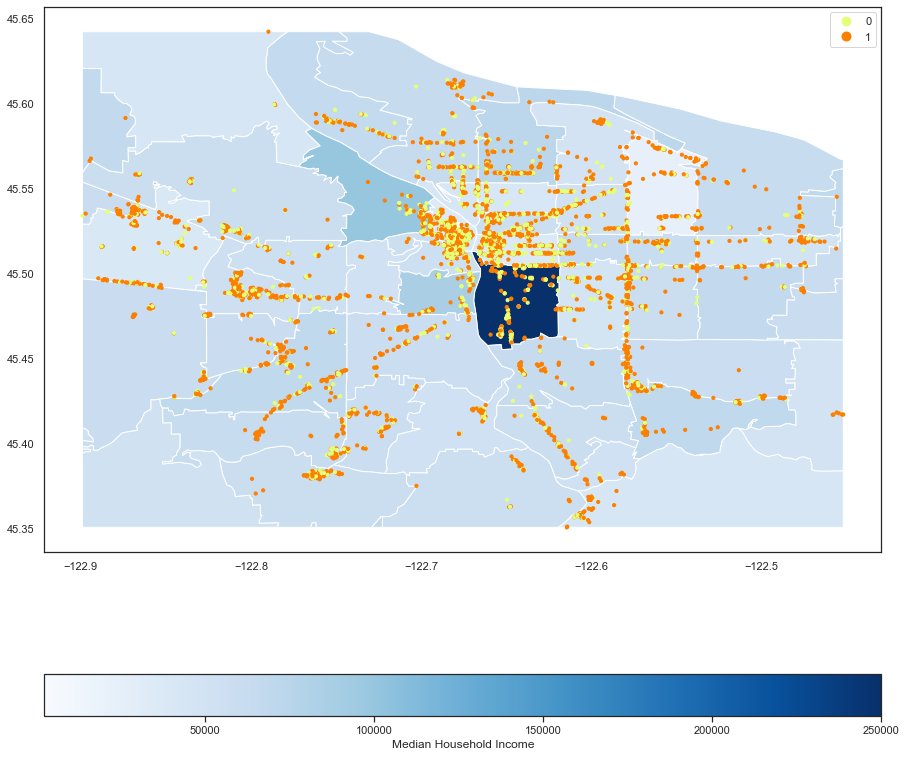

In [29]:
base=zipgeo.plot(column='median_household_income', cmap='Blues', legend=True, legend_kwds={'label': 'Median Household Income', 'orientation': 'horizontal'}, figsize = (15, 15))
rgeo.plot('is_open', categorical=True, ax=base, markersize=10, legend=True, cmap='Wistia')

The chart below shows population and restaurant closures. We can see that the distribution of restaurants has no significant effect on the number of people. The two most populous areas are located in the west and east of the city, but we can see that the restaurants are concentrated in the center of the city. Far from the center, more restaurants survived. Therefore, we can also see from the graph that there is no significant relationship between the number of restaurants closing and the population in an area.

<AxesSubplot:>

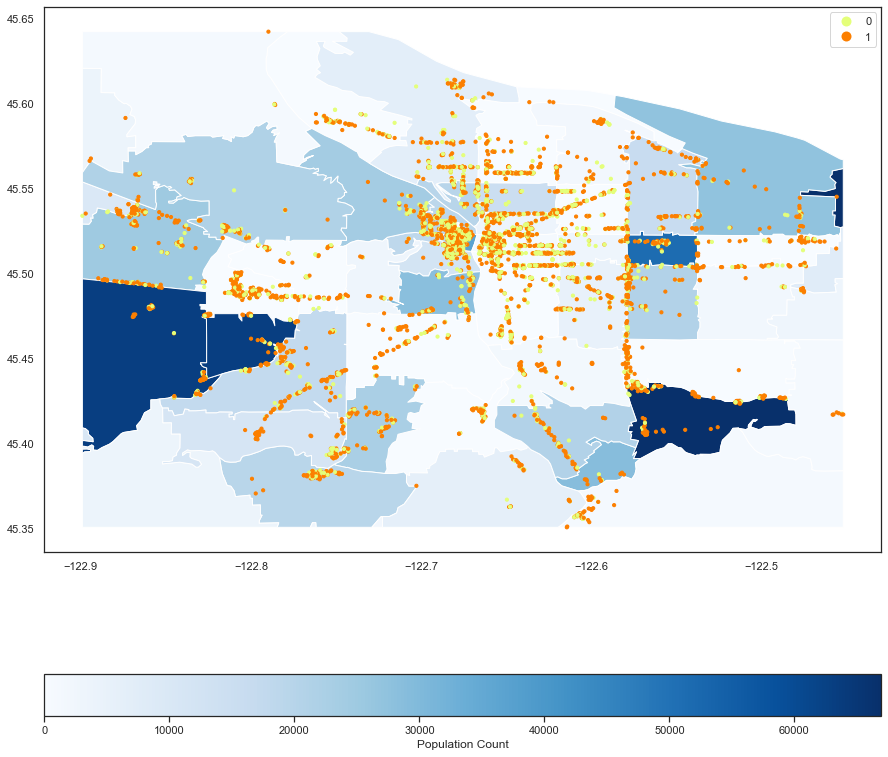

In [30]:
base=zipgeo.plot(column='Population Count', cmap='Blues', legend=True, legend_kwds={'label': 'Population Count', 'orientation': 'horizontal'}, figsize = (15, 15))
rgeo.plot('is_open', categorical=True, ax=base, markersize=10, legend=True, cmap='Wistia')

And the last graph we look at is the relationship between restaurant closures and the number of cases of COVID-19. We can observe that there is no significant change in the cases of COVID-19 in places with dense restaurants compared with other areas. However, the cases of COVID-19 are slightly higher in remote areas with fewer restaurants. But we do know that there is a direct relationship between the closure of the restaurant and COVID-19. It's pretty much the same in all of Portland, there are no particularly severe areas, and the restaurant closings as you can see here are about half of the restaurants are closed. It can be seen that the closure of restaurants is related to the COVID-19, but cannot be directly related to the number of cases in a specific area.

<AxesSubplot:>

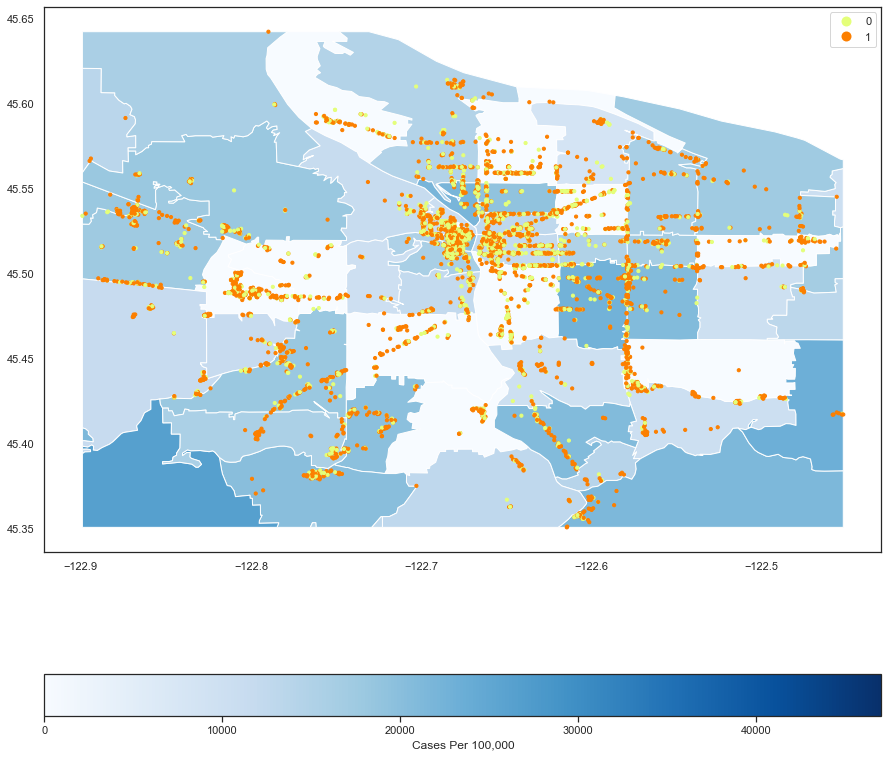

In [31]:
base=zipgeo.plot(column='Cases Per 100,000', cmap='Blues', legend=True, 
                 legend_kwds={'label': 'Cases Per 100,000', 'orientation': 'horizontal'}, 
                 figsize = (15, 15))
rgeo.plot('is_open', categorical=True, ax=base, markersize=10, legend=True, cmap='Wistia')

By fitting the linear regression model, we observed that all of the features are related to the survival of the restaurants. The number of reviews received has the highest t-value, indicating that more popular restaurants have a higher chance to survive. 

In [32]:
outcome, predictors = patsy.dmatrices('is_open ~ stars + review_log10 + income + price + cases', restaurant)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                is_open   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     203.9
Date:                Tue, 17 May 2022   Prob (F-statistic):          2.30e-200
Time:                        13:46:11   Log-Likelihood:                -3528.6
No. Observations:                5631   AIC:                             7069.
Df Residuals:                    5625   BIC:                             7109.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1514      0.059     -2.551   

# Ethics & Privacy

All the datasets we used are open datasets published on Yelp Open Dataset and California Open Data Portal that do not contain any personally identifiable information like IDs, names, etc. To use the restaurant information from Yelp, we agreed with its Dataset License that we will only use this dataset for academic or non-commercial purposes. Also, datasets we obtained from California Open Data Portal have no restriction on public use. We took personal privacy into consideration and attempted to avoid any discrimination during our project.

Though our intention of the research is to help restaurants to find ways to survive through the pandemic, once we find a significant factor that results in restaurant closing, it may go against some restaurants that are opening and they may be offended. However, this research can also serve as a warning to restaurants that do not perform well so they can examine themselves and improve. After considering the possible outcomes of the research, we believe that its benefits outweigh its disadvantages. 

https://s3-media0.fl.yelpcdn.com/assets/srv0/engineering_pages/bea5c1e92bf3/assets/vendor/yelp-dataset-agreement.pdf

# Conclusion & Discussion

After analyzing the data and running the model, we found that stars and prices have a negative effect on the survival of the restaurants. Whereas the number of reviews, the number of covid cases per 100,000 of the area, and the median household income of the area have a positive correlation with the survival of the restaurants. The results generally agree with our hypothesis that lower prices, a higher number of reviews received, and location in higher median household income areas will increase the chances of surviving for the restaurants. Thus, during the pandemic, people tend to buy cheaper food, and restaurants that are located in richer areas and have more customers before the pandemic would maintain their advantages during the pandemic. 
However, in this project, we also observed that the number of covid cases per 100,000 can help restaurants survive and restaurants that have lower ratings have higher chances to survive. These two observations went against our hypothesis. We thought that a lower number of covid cases means safer for people to eat in a restaurant which makes more people are willing to consume in these restaurants, but the reality could be people in the places where the number of covid cases is high are less care about the pandemic so they have a higher chance of eating in restaurants. We also thought that a higher rating means that people like the restaurants. Nonetheless, later we found that the stars of a restaurant are correlated with its price, since restaurants have a higher chance of surviving with low prices, they will also have a higher chance of surviving with low stars.

Limitation: Since Yelp's data is generally focused on Portland that only one city in Oregon is included, the breadth of the data is lacking. Also, because people can easily travel within the city such that a person from a low income area can eat at a restaurant in a high income area or a person from a high covid infection rate can eat at a restaurant with a low covid infection rate. Therefore the geographic factors may not be as representative as if we could find data of restaurants at a larger scale.
Another factor that limits our result is that after we ran our model, the R-squared value is only 0.162, which means that the data are not close to the regression line. However, since the output is binary and human activity is such a hard topic to predict, the results are still acceptable.


# Team Contributions

Project Proposal: Cecilia Hong, Shirui Huang, Zifan Zhang, Liuyi Zhao, Xun Zhu<br>
Data: Cecilia Hong, Shirui Huang, Zifan Zhang, Liuyi Zhao, Xun Zhu<br>
EDA: Cecilia Hong, Shirui Huang, Zifan Zhang, Liuyi Zhao, Xun Zhu<br>
Coding: Cecilia Hong, Shirui Huang, Zifan Zhang, Liuyi Zhao, Xun Zhu<br>
Word Analysis: Cecilia Hong, Shirui Huang, Zifan Zhang, Liuyi Zhao, Xun Zhu<br>
Video: Cecilia Hong, Shirui Huang, Zifan Zhang, Liuyi Zhao, Xun Zhu<br>

